In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
rcParams['figure.figsize'] = 11.7,8.27 # figure size in inches

pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 500) 
pd.set_option('display.max_columns', 30) 

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%config Completer.use_jedi = False

import joblib

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import *

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import VotingClassifier


from IPython.display import display

In [2]:
df_temporal = pd.read_csv('CSV/df_temporal.csv')

X = df_temporal.iloc[:,:-1]
y = df_temporal['Stage_Progress']

X_train_temporal, X_test_temporal, y_train_temporal, y_test_temporal = train_test_split(X, y, test_size=0.2, random_state=0)

<IPython.core.display.Javascript object>

### Preprocess

In [3]:
# Preprocess data

# Select categorical columns
categorical_cols = ['race', 'gender']

# Select numerical columns
numerical_cols = list(df_temporal.columns[:-4]) + ['age']

# Preprocessing for numerical data
numerical_transformer = StandardScaler()

# Preprocessing for categorical data
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Bundle preprocessing for numerical and categorical data
cltf = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

In [4]:
# For ensemble
def get_predictions(model, preds, X_test, algoname):

    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:,1] # only get probability for 1

    preds[algoname] = {
    'pred': y_pred,
    'pred_proba': y_pred_proba
    }
    
    return preds

# Build models
## Generate result and store in dict
* Set weight to prevent bias, 4 to CKD (1), 1 to non-CKD (0)
* Implement GridSearchCV to find the best parameters

In [5]:
def train_model(model, parameters, algoname, X_train, X_test, y_train, preds, months_name):

    print('========================================')
    print('Training %s ' % algoname)
    print()
    
    cltf.fit(X_train)
    
    scores = ['f1']
    
    # retain for loop in case want to try different scores
    for score in scores:

        print("# Tuning hyper-parameters for %s" % score)
        print()

        pipe = Pipeline(steps=[('preprocessor', cltf),
                          ('model', model)])

        search = GridSearchCV(pipe, parameters, n_jobs=-1)
        search.fit(X_train, y_train)
        
        print("Best parameter (CV score=%0.3f):" % search.best_score_)
        print()
        print("Best parameters set found on development set:")
        print()
        print(search.best_params_)
        print()
        print("Grid scores on development set:")
        print()
        means = search.cv_results_['mean_test_score']
        stds = search.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, search.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r"
                  % (mean, std * 2, params))
       
        # Obtained best model
        optimized_model = search.best_estimator_
        
        # Save model
        joblib.dump(optimized_model, 'models/' + months_name + '/'+ algoname +'.joblib')
        
        # Get predictions
        y_pred = optimized_model.predict(X_test)
        y_pred_proba = optimized_model.predict_proba(X_test)[:,1] # only get probability for 1
        
        preds[algoname] = {
        'pred': y_pred,
        'pred_proba': y_pred_proba
    }        
        
        return preds

In [6]:
# Logistic regression
model_lr = LogisticRegression(random_state=0, max_iter=10000, class_weight={0: 1, 1: 4})
parameters_lr = {'model__C': [1e-05, 1e-04, 1e-03, 1e-02, 1e-01, 1, 10, 100,1000, 1e4, 1e5, 1e6]}

# Decision tree
model_dt = DecisionTreeClassifier(random_state=0, class_weight={0: 1, 1: 4}, min_samples_leaf = 30)    
parameters_dt = {'model__max_depth': np.linspace(10, 100, 10)}

# lightGBM
model_lgbm = LGBMClassifier(n_estimators=1000, objective='binary',scale_pos_weight=4)
parameters_lgbm = {'model__learning_rate': [1e-05, 1e-04, 1e-03, 1e-02, 1e-01, 1, 10, 100]}

# Random forest
model_rf = RandomForestClassifier(class_weight={0: 1, 1: 4}, n_estimators=800, n_jobs=-1, verbose=1)
parameters_rf = {'model__max_depth': list(range(1,31))}

In [7]:
preds_temporal = {'y': y_test_temporal}

preds_temporal = train_model(model_lr, parameters_lr, 'LogisticRegression', X_train_temporal, X_test_temporal, y_train_temporal, preds_temporal, 'temporal')
preds_temporal = train_model(model_dt, parameters_dt, 'DecisionTreeClassifier', X_train_temporal, X_test_temporal, y_train_temporal, preds_temporal, 'temporal')
preds_temporal = train_model(model_lgbm, parameters_lgbm, 'LGBMClassifier', X_train_temporal, X_test_temporal, y_train_temporal, preds_temporal, 'temporal')
preds_temporal = train_model(model_rf, parameters_rf, 'RandomForestClassifier', X_train_temporal, X_test_temporal, y_train_temporal, preds_temporal, 'temporal')

joblib.dump(preds_temporal, 'predictions/predictions_temporal.joblib')

Training LogisticRegression 

# Tuning hyper-parameters for f1

Best parameter (CV score=0.633):

Best parameters set found on development set:

{'model__C': 1}

Grid scores on development set:

0.333 (+/-0.000) for {'model__C': 1e-05}
0.333 (+/-0.000) for {'model__C': 0.0001}
0.333 (+/-0.000) for {'model__C': 0.001}
0.508 (+/-0.086) for {'model__C': 0.01}
0.612 (+/-0.122) for {'model__C': 0.1}
0.633 (+/-0.176) for {'model__C': 1}
0.604 (+/-0.142) for {'model__C': 10}
0.571 (+/-0.174) for {'model__C': 100}
0.617 (+/-0.176) for {'model__C': 1000}
0.583 (+/-0.126) for {'model__C': 10000.0}
0.596 (+/-0.148) for {'model__C': 100000.0}
0.592 (+/-0.141) for {'model__C': 1000000.0}
Training DecisionTreeClassifier 

# Tuning hyper-parameters for f1

Best parameter (CV score=0.463):

Best parameters set found on development set:

{'model__max_depth': 10.0}

Grid scores on development set:

0.463 (+/-0.103) for {'model__max_depth': 10.0}
0.463 (+/-0.103) for {'model__max_depth': 20.0}
0.463 (+/-

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    0.7s finished


Best parameter (CV score=0.679):

Best parameters set found on development set:

{'model__max_depth': 29}

Grid scores on development set:

0.333 (+/-0.000) for {'model__max_depth': 1}
0.342 (+/-0.042) for {'model__max_depth': 2}
0.446 (+/-0.073) for {'model__max_depth': 3}
0.567 (+/-0.085) for {'model__max_depth': 4}
0.617 (+/-0.068) for {'model__max_depth': 5}
0.613 (+/-0.094) for {'model__max_depth': 6}
0.625 (+/-0.065) for {'model__max_depth': 7}
0.650 (+/-0.061) for {'model__max_depth': 8}
0.654 (+/-0.033) for {'model__max_depth': 9}
0.662 (+/-0.061) for {'model__max_depth': 10}
0.654 (+/-0.042) for {'model__max_depth': 11}
0.662 (+/-0.031) for {'model__max_depth': 12}
0.650 (+/-0.049) for {'model__max_depth': 13}
0.654 (+/-0.050) for {'model__max_depth': 14}
0.658 (+/-0.050) for {'model__max_depth': 15}
0.654 (+/-0.042) for {'model__max_depth': 16}
0.662 (+/-0.061) for {'model__max_depth': 17}
0.658 (+/-0.057) for {'model__max_depth': 18}
0.667 (+/-0.037) for {'model__max_depth':

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 800 out of 800 | elapsed:    0.0s finished


['predictions/predictions_temporal.joblib']

In [8]:
folder_name = 'temporal'
    
# Load models
clf1 = joblib.load('models/'+ folder_name +'/LogisticRegression.joblib')
clf2 = joblib.load('models/'+ folder_name +'/RandomForestClassifier.joblib')
clf3 = joblib.load('models/'+ folder_name +'/DecisionTreeClassifier.joblib')
clf4 = joblib.load('models/'+ folder_name +'/LGBMClassifier.joblib')

# Build ensemble
eclf = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('dt', clf3), ('lgbm', clf4)], voting='soft').fit(X_train_temporal, y_train_temporal)

# Stacked
model_stack1 = StackingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('dt', clf3), ('lgbm', clf4)], final_estimator=LogisticRegression(), cv=5).fit(X_train_temporal, y_train_temporal)
model_stack2 = StackingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('dt', clf3), ('lgbm', clf4)], final_estimator=RandomForestClassifier(), cv=5).fit(X_train_temporal, y_train_temporal)
model_stack3 = StackingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('dt', clf3), ('lgbm', clf4)], final_estimator=LGBMClassifier(), cv=5).fit(X_train_temporal, y_train_temporal)

# Get predictions
preds_temporal_ensemble = {'y': y_test_temporal}
preds_temporal_ensemble = get_predictions(eclf, preds_temporal_ensemble, X_test_temporal, 'VotingClassifier')
preds_temporal_ensemble = get_predictions(model_stack1, preds_temporal_ensemble, X_test_temporal, 'StackingClassifier_logistic')
preds_temporal_ensemble = get_predictions(model_stack2, preds_temporal_ensemble,X_test_temporal, 'StackingClassifier_rf')
preds_temporal_ensemble = get_predictions(model_stack3, preds_temporal_ensemble,X_test_temporal, 'StackingClassifier_lgbm')

joblib.dump(preds_temporal_ensemble, 'predictions/preds_temporal_ensemble.joblib')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 328 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 800 out of 800 | elaps

['predictions/preds_temporal_ensemble.joblib']

# Compare models

In [9]:
def specificity(y_valid, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_valid, y_pred).ravel()
    
    specificity = tn / (tn+fp)
    return specificity

# Performance of a dichotomous diagnostic test
def youden_index(y, pred_proba):
    fpr, tpr, thresh = roc_curve(y, pred_proba)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresh[optimal_idx]
    return optimal_threshold

# Threshold used
def get_threshold_table(preds):
    thresh = [[algo, val['threshold']] for algo, val in preds.items() if algo != 'y']
    return pd.DataFrame(thresh, columns=['Algo', "Threshold"])

In [10]:
def compute_matrics(predications, days_bin):
    # Calculate probability thresholds
    for algo, preds in predications.items():
        if algo == 'y':
            continue
        threshold = youden_index(predications['y'], preds['pred_proba'])
        preds['threshold'] = threshold
        preds['pred'] = preds['pred_proba'] >= threshold

    # Get threshold to categorize as 1 (CKD)
    threshold = pd.concat([get_threshold_table(preds) for preds in [predications]])
    pd.set_option('display.float_format', lambda x: '%.5f' % x)
    display(threshold)

    # Compute matrics
    metrics_list = []

    y_truth = predications['y']
    for algo, preds in predications.items():
        if algo == 'y':
            continue

        y_pred = preds['pred']
        y_pred_proba = preds['pred_proba']

        acc = accuracy_score(y_truth, y_pred)
        f1 = f1_score(y_truth, y_pred)
        prec = precision_score(y_truth, y_pred)
        rec = recall_score(y_truth, y_pred)
        spec = specificity(y_truth, y_pred)
        roc = roc_auc_score(y_truth, y_pred_proba)

        row = [algo, acc, f1, prec, rec, spec, roc]
        metrics_list.append(row)

    cols = ['Algorithm', 'Accuracy', 'F1', 'Precision', 'Recall', 'Specificiy', 'ROC_AUC']
    metrics = pd.DataFrame(metrics_list, columns=cols)
    display(metrics.sort_values('ROC_AUC'))


    # Plot ROC
    fig = plt.figure(figsize=(6,6))
    lw = 2

    rocs = []
    for algo, model in predications.items():
        if algo == 'y':
            continue
        fpr, tpr, thresh = roc_curve(predications['y'], predications[algo]['pred_proba'])
        auc = roc_auc_score(predications['y'], predications[algo]['pred_proba'])
        auc = round(auc, 3)
        rocs.append((algo, auc, [fpr, tpr]))
    # sort legend by AUC
    rocs = sorted(rocs, key=lambda x: x[1], reverse=True)
    for algo, auc, [fpr, tpr] in rocs:    
        plt.plot(fpr,tpr, label=algo+f' ({auc})', lw=lw)

    # chance line
    plt.plot([0, 1], [0, 1], color='navy', label='chance line (0.5)', linestyle='--', lw=lw)
    plt.xlabel('1 - Specificity')
    plt.ylabel('Sensitivity')
    # plt.title('ROC curve for 6 months', size=12)
    plt.text(0.7,0.3, days_bin, fontsize=12)
    plt.grid(linewidth=1.2, color='lightgray')
    plt.legend(loc='lower right')
    plt.savefig('figures/' + days_bin + '.jpg')


,Algo,Threshold
0,LogisticRegression,0.17300
1,DecisionTreeClassifier,0.89286
2,LGBMClassifier,0.33413
3,RandomForestClassifier,0.37000


,Algorithm,Accuracy,F1,Precision,Recall,Specificiy,ROC_AUC
1,DecisionTreeClassifier,0.71667,0.45161,0.63636,0.35000,0.90000,0.61688
2,LGBMClassifier,0.60000,0.57143,0.44444,0.80000,0.50000,0.68125
0,LogisticRegression,0.63333,0.59259,0.47059,0.80000,0.55000,0.68500
3,RandomForestClassifier,0.80000,0.68421,0.72222,0.65000,0.87500,0.78125


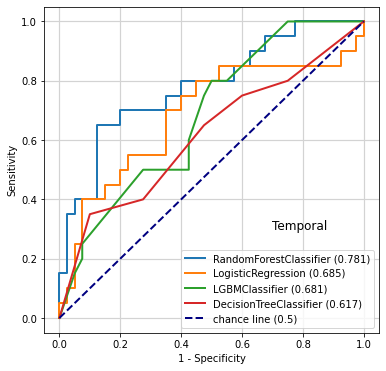

In [11]:
compute_matrics(joblib.load('predictions/predictions_temporal.joblib'), 'Temporal')

,Algo,Threshold
0,VotingClassifier,0.55438
1,StackingClassifier_logistic,0.39980
2,StackingClassifier_rf,0.33000
3,StackingClassifier_lgbm,0.73292


,Algorithm,Accuracy,F1,Precision,Recall,Specificiy,ROC_AUC
3,StackingClassifier_lgbm,0.71667,0.41379,0.66667,0.30000,0.92500,0.57125
2,StackingClassifier_rf,0.61667,0.54902,0.45161,0.70000,0.57500,0.58875
0,VotingClassifier,0.80000,0.60000,0.90000,0.45000,0.97500,0.71125
1,StackingClassifier_logistic,0.75000,0.57143,0.66667,0.50000,0.87500,0.74250


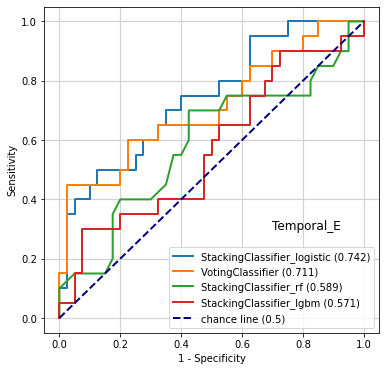

In [12]:
compute_matrics(joblib.load('predictions/preds_temporal_ensemble.joblib'), 'Temporal_E')